# ANLY 580 Project 2 Test

## Topic Modeling

### Imported Package 

In [21]:
import pandas as pd
import missingno as msno 

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

#LDA
import pandas as pd
import numpy as np

import os
import gensim
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, HdpModel

from nltk.corpus import stopwords
import string
import re
from pprint import pprint

from collections import OrderedDict

import seaborn as sns

import pyLDAvis.gensim

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords

from tqdm import tqdm

In [26]:
#read file
df = pd.read_csv("steam_reviews.csv")

### Data Clean

In [6]:
df_clean = df[df.review.notnull()] #filter missing value

In [7]:
df_clean = df_clean[df_clean['helpful'] != 0] #filter non-helpful review

In [8]:
df_clean.count() #count for each column

date_posted               35071
funny                     35071
helpful                   35071
hour_played               35071
is_early_access_review    35071
recommendation            35071
review                    35071
title                     35071
dtype: int64

In [9]:
# NLTK Stop words
# Define our stoplist for removing common words and tokenizing
list1 = ['RT','rt', '&amp;', 'im', 'b4', 'yr', 'nd', 'rd', 'oh', "can't", "he's", "i'll",
         "i'm", 'ta', "'s", "c'mon", 'th', 'st', "that's", "they're", "i've", 'am', 'pm']
list2 = ['good','nice','awesome','cool','perfect','like','very','&gt','well','sucks','damn','bad','great','XD','&lt','best','ok','suck','shit','s','u','c','k','garbage','noob','trash','game','get','yes','play',' ','man']
stoplist = stopwords.words('english') + list(string.punctuation) + list1 + list2

In [10]:
# prepare corpus for recommendation column
def cleancom(documents):
    corpus_rec = []

    for i in documents['review']:
        comm = i

        comm = re.sub(r'http\S+', '', comm) #remove url's 

        #remove hashtags and mentions
        comm = re.sub(r'#\w+ ?', '', comm)
        comm = re.sub(r'@\w+ ?', '', comm)
        comm = comm.replace("&amp;", " ").replace("&gt;", "").replace("&lt;", "")
        comm = comm.replace("(", "").replace(")", "").replace(".", "").replace("?", "").replace("!", "").replace(",", "")
        comm = comm.replace("/", " ").replace("=", "").replace('\"', "").replace('*', '').replace(';', "")
        comm = comm.replace(':', '').replace('"', '')
        comm = re.sub(r'\$[0-9]+', '', comm)
        comm = re.sub(r'[0-9]+GB', '', comm)
        comm = re.sub(r'[0-9]+', '', comm)
        comm = re.sub(r'--+', ' ', comm)
        comm = comm.encode("ascii", errors="ignore").decode()

        corpus_rec.append(comm)

    return(corpus_rec)

### Topic Modeling

#### Subset 1: recommended game review

In [16]:
rec = df_clean[df_clean['recommendation'] =='Recommended']

In [17]:
rec.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight
5,2016-12-12,4,55,2694,False,Recommended,ENGLISH After playing for more than two years ...,Dead by Daylight
6,2017-09-17,12,228,48,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight


In [18]:
corpus_rec = cleancom(rec)

In [19]:
# Remove stopwords
texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus_rec]

# Create and save the dictionary
dictionary = corpora.Dictionary(texts)
#dictionary.save(os.path.join(TEMP_FOLDER, 'semval.dict'))  # store the dictionary, for future reference

In [20]:
#corpus EDA
text_length = []
for t in texts:
    text_length.append(len(t))
    
rec['doc_length'] = text_length

avg_doc_length = rec['doc_length'].mean() 
median_doc_length = rec['doc_length'].median()
min_doc_length = rec['doc_length'].min()
max_doc_length = rec['doc_length'].max()

print("Average comment length: {}".format(avg_doc_length))
print("Median comment length: {}".format(median_doc_length))
print("Minimum comment length: {}".format(min_doc_length))
print("Maximum comment length: {}".format(max_doc_length))

Average comment length: 21.02012993929066
Median comment length: 6.0
Minimum comment length: 0
Maximum comment length: 788


In [21]:
#define outliers
rec_filtered = rec[rec['doc_length'] > 700]
rec_filtered.head()

outliers = rec_filtered['review']
print(outliers)

110420    What a rollercoaster of a game.Starting the ga...
114463    A Masterpiece thats worth the waitIn a world f...
123276    Now this is going to be a difficult kind of Re...
136466    Donald J. Trump is the very definition of the ...
214540    In A Nutshell Pros + Charming post apocalyptic...
254324    Roman Catholic sign of the cross is upside dow...
Name: review, dtype: object


In [23]:
corpus_rec = [dictionary.doc2bow(text) for text in texts]

In [24]:
tfidf = models.TfidfModel(corpus_rec) # step 1 -- initialize a model
corpus_rec_tfidf = tfidf[corpus_rec]      # step 2 -- use the model to transform vectors

###### find optimal number of topics

In [23]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return (model_list, coherence_values)

In [26]:
limit=31; start=1; step=5;

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus_rec, 
                                                        texts=texts,
                                                        limit=limit, start=start, 
                                                        step=step)

100%|██████████| 6/6 [05:15<00:00, 53.82s/it]


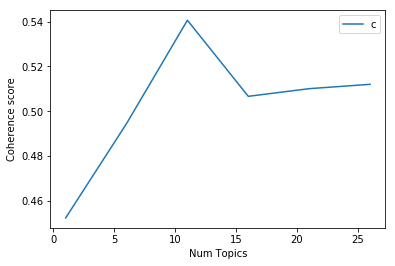

In [27]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

We learned that the optimal number of topic is 11. Below we print out the topics below, as well as the top 5 key words for each topics.

In [30]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=5))

[(0,
  '0.018*"back" + 0.015*"found" + 0.013*"started" + 0.013*"friend" + '
  '0.010*"people"'),
 (1,
  '0.014*"games" + 0.007*"weapons" + 0.007*"gameplay" + 0.007*"bit" + '
  '0.007*"combat"'),
 (2,
  '0.205*"fun" + 0.098*"friends" + 0.071*"playing" + 0.041*"recommend" + '
  '0.035*"pretty"'),
 (3,
  '0.033*"make" + 0.020*"add" + 0.019*"minutes" + 0.017*"place" + 0.016*"top"'),
 (4, '0.041*"pc" + 0.026*"fps" + 0.018*"graphics" + 0.017*"fix" + 0.016*"run"'),
 (5,
  '0.051*"love" + 0.032*"ing" + 0.031*"simulator" + 0.025*"life" + '
  '0.021*"chicken"'),
 (6,
  '0.027*"pubg" + 0.021*"battle" + 0.017*"china" + 0.016*"hz" + 0.016*"map"'),
 (7,
  '0.066*"gta" + 0.063*"online" + 0.031*"money" + 0.026*"rockstar" + '
  '0.024*"mode"'),
 (8,
  '0.031*"naked" + 0.027*"killed" + 0.027*"join" + 0.025*"guy" + 0.021*"rock"'),
 (9,
  '0.083*"buy" + 0.078*"played" + 0.070*"games" + 0.046*"amazing" + '
  '0.031*"worth"'),
 (10,
  '0.063*"people" + 0.051*"rust" + 0.032*"server" + 0.030*"community" + '
 

In [32]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_rec,
                                           id2word=dictionary,
                                           num_topics=11, 
                                           random_state=100,
                                           update_every=2,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_rec, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.391186  0.243296       1        1  58.602810
10    -0.219154 -0.224836       2        1  12.407424
2     -0.076440 -0.255871       3        1   9.007426
0     -0.044005 -0.060349       4        1   8.138487
8      0.007341  0.024659       5        1   4.456108
4      0.024877  0.128004       6        1   2.493892
6      0.133297  0.025617       7        1   1.571205
7      0.136023  0.028118       8        1   1.026535
3      0.139959  0.029007       9        1   0.982371
9      0.143245  0.030474      10        1   0.875249
5      0.146043  0.031883      11        1   0.438499, topic_info=      Category         Freq           Term        Total  loglift  logprob
42     Default  2994.000000            fun  2994.000000  30.0000  30.0000
18182  Default  1877.000000          naked  1877.000000  29.0000  29.0000
2538   Default  1757.000000           base  1757.000000  28.0000  28.0000
156    Default  1875.000000          hours  1875.000000  27.0000  27.0000
1162   Default   706.000000           free   706.000000  26.0000  26.0000
1512   Default  1295.000000       survival  1295.000000  25.0000  25.0000
1312   Default   522.000000        product   522.000000  24.0000  24.0000
1313   Default   516.000000       received   516.000000  23.0000  23.0000
1067   Default   939.000000            day   939.000000  22.0000  22.0000
4645   Default   731.000000         skyrim   731.000000  21.0000  21.0000
5131   Default   775.000000           shot   775.000000  20.0000  20.0000
67     Default  1924.000000           make  1924.000000  19.0000  19.0000
8583   Default  3656.000000           rust  3656.000000  18.0000  18.0000
504    Default   901.000000          build   901.000000  17.0000  17.0000
236    Default   669.000000           bugs   669.000000  16.0000  16.0000
1446   Default   827.000000            guy   827.000000  15.0000  15.0000
79     Default  3294.000000         people  3294.000000  14.0000  14.0000
539    Default   698.000000           long   698.000000  13.0000  13.0000
855    Default  1207.000000           back  1207.000000  12.0000  12.0000
1391   Default   600.000000           gets   600.000000  11.0000  11.0000
781    Default  2904.000000          would  2904.000000  10.0000  10.0000
152    Default   673.000000           hard   673.000000   9.0000   9.0000
129    Default  1239.000000         around  1239.000000   8.0000   8.0000
314    Default   631.000000       graphics   631.000000   7.0000   7.0000
76     Default  3133.000000            one  3133.000000   6.0000   6.0000
3982   Default   633.000000       building   633.000000   5.0000   5.0000
6411   Default   612.000000         raided   612.000000   4.0000   4.0000
2405   Default   501.000000            fps   501.000000   3.0000   3.0000
80     Default  1234.000000        players  1234.000000   2.0000   2.0000
7234   Default   513.000000        chicken   513.000000   1.0000   1.0000
...        ...          ...            ...          ...      ...      ...
1280   Topic11   107.868202           join   108.603340   5.4228  -2.7754
1104   Topic11    75.982246      screaming    76.717415   5.4199  -3.1258
8660   Topic11    31.521729         female    32.256954   5.4065  -4.0057
1815   Topic11    25.920626            pig    26.655720   5.4016  -4.2013
1895   Topic11    17.171480          agree    17.906660   5.3876  -4.6131
7717   Topic11    16.650467         gender    17.385962   5.3863  -4.6439
1065   Topic11    14.212298         search    14.947475   5.3791  -4.8022
6228   Topic11    13.848123        invited    14.583308   5.3778  -4.8282
31434  Topic11    12.825326       house&gt    13.560864   5.3738  -4.9049
26989  Topic11    11.725985     screeching    12.461061   5.3688  -4.9945
28699  Topic11     9.970442     friends&gt    10.705637   5.3584  -5.1567
1903   Topic11     9.652801       memories    10.387991   5.3562  -5.1891

Above is the visualization of all topics. Distance represents the difference between topics, and size represents the number of reviews containing in the corresponding topic. On the right, the bar chart shows the eastimated term frequency. Blue is the overall term frequency, and red is term frequency within the selected topic.

Topic: 
Apparently, we can see there are some disctinct topics: 

1. game description: some reviews are mainly talking about the game. These topics have key word like weapons, multiplayer, simulator, car, etc. 
2. game experience: some reviews are talking about their experience in the game, we learned these from key words like desgin, server, etc.
3. optimization: some reviews are using keyword like graphic, server, these are obviously talking about optimization of the games. 

#### Subset 2 : Non Recommended game reviews

In [11]:
rec = df_clean[df_clean['recommendation'] =='Not Recommended']

In [12]:
rec.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
129,2018-02-21,1,1,575,False,Not Recommended,Terrible game! When you exit the game there is...,Dead by Daylight
144,2017-02-17,1,1,93,False,Not Recommended,Game was nice and fun i enjoyed playing it. Yo...,Dead by Daylight
185,2017-01-05,1,1,816,False,Not Recommended,&gt I have created a video of my afterthoughts...,Dead by Daylight
241,2016-06-24,1,1,7,False,Not Recommended,this game is so annoying to play when people b...,Dead by Daylight
243,2016-06-27,2,1,24,False,Not Recommended,Its a good game but the community is on times ...,Dead by Daylight


In [13]:
corpus_NR = cleancom(rec)

In [14]:
# Remove stopwords
texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus_NR]

# Create and save the dictionary
dictionary = corpora.Dictionary(texts)
#dictionary.save(os.path.join(TEMP_FOLDER, 'semval.dict'))  # store the dictionary, for future reference

In [16]:
#corpus EDA
text_length = []
for t in texts:
    text_length.append(len(t))
    
rec['doc_length'] = text_length

avg_doc_length = rec['doc_length'].mean() 
median_doc_length = rec['doc_length'].median()
min_doc_length = rec['doc_length'].min()
max_doc_length = rec['doc_length'].max()

print("Average comment length: {}".format(avg_doc_length))
print("Median comment length: {}".format(median_doc_length))
print("Minimum comment length: {}".format(min_doc_length))
print("Maximum comment length: {}".format(max_doc_length))

Average comment length: 27.68219480758608
Median comment length: 10.0
Minimum comment length: 0
Maximum comment length: 1200


In [17]:
#define outliers
rec_filtered = rec[rec['doc_length'] > 800]
rec_filtered.head()

outliers = rec_filtered['review']
print(outliers)

258170    BETTER BUY FORTNITE BETTER BUY FORTNITE BETTER...
286106    REGION LOCK CHINA REGION LOCK CHINA REGION LOC...
376544    t update....Really really really really really...
Name: review, dtype: object


In [18]:
corpus_NR = [dictionary.doc2bow(text) for text in texts]

In [19]:
tfidf = models.TfidfModel(corpus_NR) # step 1 -- initialize a model
corpus_rec_tfidf = tfidf[corpus_NR]      # step 2 -- use the model to transform vectors

In [24]:
limit=31; start=1; step=5;

model_list_NR, coherence_values_NR = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus_NR, 
                                                        texts=texts,
                                                        limit=limit, start=start, 
                                                        step=step)

100%|██████████| 6/6 [05:26<00:00, 56.48s/it]


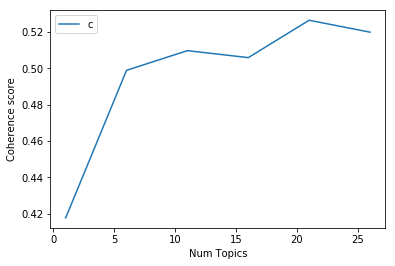

In [25]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values_NR)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
# Select the model and print the topics 
optimal_model_NR = model_list_NR[3]
model_topics_NR = optimal_model_NR.show_topics(formatted=False)
pprint(optimal_model_NR.print_topics(num_words=5))

[(0,
  '0.057*"free" + 0.035*"product" + 0.032*"received" + 0.030*"terrible" + '
  '0.028*"yeet"'),
 (1,
  '0.044*"hackers" + 0.034*"players" + 0.032*"pubg" + 0.027*"cheaters" + '
  '0.026*"devs"'),
 (2,
  '0.021*"monster" + 0.013*"weapons" + 0.012*"time" + 0.011*"monsters" + '
  '0.010*"hunter"'),
 (3,
  '0.058*"banned" + 0.032*"reason" + 0.031*"ban" + 0.029*"support" + '
  '0.028*"steam"'),
 (4,
  '0.020*"players" + 0.018*"killer" + 0.018*"team" + 0.018*"match" + '
  '0.017*"system"'),
 (5,
  '0.065*"fix" + 0.061*"servers" + 0.032*"waiting" + 0.027*"bugs" + '
  '0.025*"chinese"'),
 (6,
  '0.019*"time" + 0.017*"games" + 0.014*"experience" + 0.012*"long" + '
  '0.010*"simply"'),
 (7,
  '0.150*"buy" + 0.115*"money" + 0.043*"fortnite" + 0.031*"waste" + '
  '0.026*"worth"'),
 (8,
  '0.051*"pc" + 0.036*"fps" + 0.031*"lock" + 0.029*"wait" + 0.023*"graphics"'),
 (9,
  '0.074*"online" + 0.050*"gta" + 0.034*"rockstar" + 0.028*"player" + '
  '0.028*"single"'),
 (10,
  '0.038*"make" + 0.032*"peo

In [54]:
# Build LDA model
lda_model_NR = gensim.models.ldamodel.LdaModel(corpus=corpus_NR,
                                           id2word=dictionary,
                                           num_topics=11, 
                                           random_state=100,
                                           update_every=2,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis_NR = pyLDAvis.gensim.prepare(lda_model_NR, corpus_NR, dictionary)
vis_NR

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.407529  0.076844       1        1  55.181992
7      0.372988  0.047276       2        1  27.014711
1      0.037682 -0.399731       3        1   6.674173
5     -0.025612 -0.031335       4        1   3.880001
0     -0.106366  0.045042       5        1   1.697855
6     -0.105553  0.044671       6        1   1.562047
10    -0.101986  0.044096       7        1   1.418077
9     -0.108257  0.045106       8        1   1.381261
4     -0.121397  0.044453       9        1   0.708046
8     -0.124127  0.042426      10        1   0.378384
2     -0.124901  0.041153      11        1   0.103447, topic_info=      Category         Freq          Term        Total  loglift  logprob
390    Default  6178.000000        really  6178.000000  30.0000  30.0000
523    Default  1547.000000           ing  1547.000000  29.0000  29.0000
2334   Default  1021.000000          mods  1021.000000  28.0000  28.0000
8405   Default  1135.000000        skyrim  1135.000000  27.0000  27.0000
36     Default  1206.000000           fps  1206.000000  26.0000  26.0000
4248   Default  2236.000000          rust  2236.000000  25.0000  25.0000
1830   Default   877.000000          lock   877.000000  24.0000  24.0000
2344   Default   707.000000       version   707.000000  23.0000  23.0000
1351   Default   868.000000      graphics   868.000000  22.0000  22.0000
4175   Default   430.000000      bethesda   430.000000  21.0000  21.0000
933    Default   555.000000         crash   555.000000  20.0000  20.0000
24     Default  3111.000000           buy  3111.000000  19.0000  19.0000
3932   Default   407.000000         china   407.000000  18.0000  18.0000
109    Default  1286.000000          kill  1286.000000  17.0000  17.0000
4244   Default   489.000000        region   489.000000  16.0000  16.0000
7045   Default   583.000000          loot   583.000000  15.0000  15.0000
156    Default  2752.000000        better  2752.000000  14.0000  14.0000
381    Default   470.000000           mod   470.000000  13.0000  13.0000
12     Default  1859.000000       players  1859.000000  12.0000  12.0000
418    Default   557.000000       loading   557.000000  11.0000  11.0000
2469   Default   548.000000       crashes   548.000000  10.0000  10.0000
818    Default  1148.000000          find  1148.000000   9.0000   9.0000
22     Default  1053.000000        around  1053.000000   8.0000   8.0000
67     Default  2361.000000         still  2361.000000   7.0000   7.0000
2843   Default   493.000000          load   493.000000   6.0000   6.0000
582    Default  2310.000000        server  2310.000000   5.0000   5.0000
459    Default   309.000000        random   309.000000   4.0000   4.0000
197    Default   300.000000         piece   300.000000   3.0000   3.0000
689    Default   396.000000      computer   396.000000   2.0000   2.0000
1357   Default   469.000000      settings   469.000000   1.0000   1.0000
...        ...          ...           ...          ...      ...      ...
472    Topic11     1.347241          loud     2.110585   6.4250  -5.8474
2001   Topic11     0.942491             q     1.705811   6.2806  -6.2047
1165   Topic11     0.747439        facing     1.510773   6.1701  -6.4365
581    Topic11     0.335203            pw     1.098499   5.6869  -7.2384
580    Topic11     0.156938            pp     0.920242   5.1051  -7.9973
32954  Topic11     0.015543            sf     0.857496   2.8635 -10.3096
37511  Topic11     0.011688        nudist     0.779342   2.6740 -10.5946
9300   Topic11     0.011688         probs     0.779945   2.6732 -10.5946
33511  Topic11     0.011688         booty     0.781036   2.6718 -10.5946
3709   Topic11     0.011870         grown     0.802691   2.6599 -10.5792
34532  Topic11     0.011344   impossieble     0.780211   2.6430 -10.6245
19618  Topic11     0.011361          slit     0.782861   2.6411 -10.6230
37398  Topic11     0.011355         putin  

Topic: 
We do observe there are some distinctive topics which are listed below.

1. Game Description: part of reviews is describing the basic features of games
2. Games experience: one of the topic is complainting the wait time is too long which might cause by internet or bugs in game, it has key words like: loading, waiting, time
3. Gaming company operation: there is a topic is complaining about the operation of the game company. It mentioned key word like: release, update, early, access

#### Subset 3 : PUBG Review (Player Unkown BattleGround)

In [55]:
PUBG = df_clean[df_clean['title'] =='PLAYERUNKNOWN\'S BATTLEGROUNDS']

In [56]:
PUBG.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
214786,2017-10-13,1,3,348,True,Not Recommended,A very fun concept of a game. Very addicting. ...,PLAYERUNKNOWN'S BATTLEGROUNDS
214788,2018-04-25,1,3,12,False,Not Recommended,I honestly wish I could refund this game... th...,PLAYERUNKNOWN'S BATTLEGROUNDS
214790,2017-12-22,1,3,549,False,Not Recommended,Piece of crap on EU servers since weeks. Heavy...,PLAYERUNKNOWN'S BATTLEGROUNDS
214794,2018-01-27,1,3,442,False,Not Recommended,Playerunknown's cheating grounds,PLAYERUNKNOWN'S BATTLEGROUNDS
214795,2018-07-13,1,3,166,False,Not Recommended,minha pesonagem nao tem uma raba q da tsao.com...,PLAYERUNKNOWN'S BATTLEGROUNDS


In [57]:
corpus_pubg = cleancom(PUBG)

In [58]:
# Remove stopwords
texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus_pubg]

# Create and save the dictionary
dictionary = corpora.Dictionary(texts)
#dictionary.save(os.path.join(TEMP_FOLDER, 'semval.dict'))  # store the dictionary, for future reference

In [59]:
#corpus EDA
text_length = []
for t in texts:
    text_length.append(len(t))
    
PUBG['doc_length'] = text_length

avg_doc_length = PUBG['doc_length'].mean() 
median_doc_length = PUBG['doc_length'].median()
min_doc_length = PUBG['doc_length'].min()
max_doc_length = PUBG['doc_length'].max()

print("Average comment length: {}".format(avg_doc_length))
print("Median comment length: {}".format(median_doc_length))
print("Minimum comment length: {}".format(min_doc_length))
print("Maximum comment length: {}".format(max_doc_length))

Average comment length: 20.079381608458828
Median comment length: 7.0
Minimum comment length: 0
Maximum comment length: 1200


In [60]:
PUBG_filtered = PUBG[PUBG['doc_length'] > 700]
PUBG_filtered.head()

outliers = PUBG_filtered['review']
print(outliers)

254324    Roman Catholic sign of the cross is upside dow...
258170    BETTER BUY FORTNITE BETTER BUY FORTNITE BETTER...
286106    REGION LOCK CHINA REGION LOCK CHINA REGION LOC...
Name: review, dtype: object


In [61]:
#print(dictionary.token2id)

In [62]:
corpus_pubg = [dictionary.doc2bow(text) for text in texts]

In [63]:
tfidf = models.TfidfModel(corpus_pubg) # step 1 -- initialize a model
corpus_tfidf = tfidf[corpus_pubg]      # step 2 -- use the model to transform vectors

In [64]:
limit=31; start=1; step=5;

model_list_pubg, coherence_values_pubg = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus_pubg, 
                                                        texts=texts,
                                                        limit=limit, start=start, 
                                                        step=step)


100%|██████████| 6/6 [04:49<00:00, 49.12s/it]

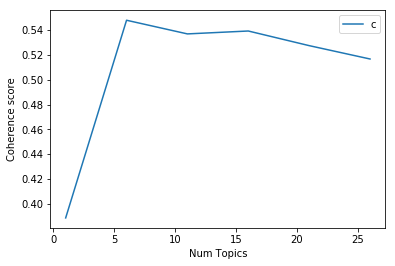

In [65]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values_pubg)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [66]:
# Select the model and print the topics
optimal_model_pubg = model_list_pubg[2]
model_topics_pubg = optimal_model_pubg.show_topics(formatted=False)
pprint(optimal_model_pubg.print_topics(num_words=5))

[(0,
  '0.045*"bugs" + 0.040*"hours" + 0.021*"make" + 0.017*"time" + 0.016*"hard"'),
 (1,
  '0.052*"free" + 0.039*"product" + 0.038*"received" + 0.035*"love" + '
  '0.024*"ready"'),
 (2,
  '0.031*"map" + 0.021*"issues" + 0.013*"fixed" + 0.012*"problems" + '
  '0.011*"weapons"'),
 (3,
  '0.047*"people" + 0.033*"played" + 0.021*"games" + 0.018*"times" + '
  '0.017*"person"'),
 (4, '0.020*"shot" + 0.019*"loot" + 0.018*"kill" + 0.017*"find" + 0.013*"die"'),
 (5,
  '0.024*"players" + 0.023*"devs" + 0.021*"people" + 0.020*"make" + '
  '0.019*"developers"'),
 (6, '0.040*"fps" + 0.039*"early" + 0.032*"access" + 0.024*"pc" + 0.022*"run"'),
 (7,
  '0.091*"fun" + 0.054*"pubg" + 0.039*"friends" + 0.033*"games" + '
  '0.033*"battle"'),
 (8,
  '0.049*"servers" + 0.046*"hackers" + 0.045*"china" + 0.041*"lock" + '
  '0.037*"chinese"'),
 (9,
  '0.039*"server" + 0.036*"time" + 0.036*"lag" + 0.027*"update" + '
  '0.020*"playing"'),
 (10,
  '0.100*"buy" + 0.070*"ing" + 0.063*"fortnite" + 0.052*"dont" + '


In [67]:
# Build LDA model
lda_model_pubg = gensim.models.ldamodel.LdaModel(corpus=corpus_pubg,
                                           id2word=dictionary,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=2,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis_pubg = pyLDAvis.gensim.prepare(lda_model_pubg, corpus_pubg, dictionary)
vis_pubg

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.318006  0.217109       1        1  46.519569
3     -0.243767 -0.259942       2        1  34.618603
1      0.134536  0.093170       3        1   6.894541
4      0.161068 -0.010647       4        1   5.192839
5      0.123686 -0.027226       5        1   3.490062
2      0.142484 -0.012463       6        1   3.284397, topic_info=      Category         Freq             Term        Total  loglift  logprob
777    Default  1117.000000             lock  1117.000000  30.0000  30.0000
93     Default   855.000000            china   855.000000  29.0000  29.0000
289    Default   673.000000             free   673.000000  28.0000  28.0000
783    Default   637.000000           region   637.000000  27.0000  27.0000
298    Default   545.000000          product   545.000000  26.0000  26.0000
299    Default   519.000000         received   519.000000  25.0000  25.0000
498    Default  1815.000000              buy  1815.000000  24.0000  24.0000
22171  Default   504.000000      chinaregion   504.000000  23.0000  23.0000
26548  Default   377.000000             nmsl   377.000000  22.0000  22.0000
293    Default  1656.000000              ing  1656.000000  21.0000  21.0000
9879   Default  1541.000000             yeet  1541.000000  20.0000  20.0000
82     Default  1535.000000           better  1535.000000  19.0000  19.0000
508    Default   374.000000            crash   374.000000  18.0000  18.0000
24     Default  1384.000000              fun  1384.000000  17.0000  17.0000
464    Default  1505.000000           people  1505.000000  16.0000  16.0000
393    Default   320.000000                e   320.000000  15.0000  15.0000
196    Default  1326.000000            still  1326.000000  14.0000  14.0000
1278   Default   305.000000           banned   305.000000  13.0000  13.0000
405    Default  1055.000000           review  1055.000000  12.0000  12.0000
120    Default  1041.000000         fortnite  1041.000000  11.0000  11.0000
647    Default   282.000000          chinese   282.000000  10.0000  10.0000
41     Default  1016.000000            money  1016.000000   9.0000   9.0000
416    Default   270.000000             long   270.000000   8.0000   8.0000
996    Default   943.000000              fps   943.000000   7.0000   7.0000
659    Default   355.000000           please   355.000000   6.0000   6.0000
477    Default   894.000000            steam   894.000000   5.0000   5.0000
831    Default   194.000000                f   194.000000   4.0000   4.0000
50     Default   875.000000           really   875.000000   3.0000   3.0000
714    Default   869.000000             much   869.000000   2.0000   2.0000
105    Default   870.000000             dont   870.000000   1.0000   1.0000
...        ...          ...              ...          ...      ...      ...
2662    Topic6   123.825066              gay   124.552551   3.4101  -4.1970
1996    Topic6    97.900337            quite    98.634872   3.4085  -4.4320
1807    Topic6    90.742798          driving    91.477837   3.4079  -4.5079
2048    Topic6    88.051346         crashing    88.790588   3.4076  -4.5380
1888    Topic6    87.328827             beta    88.063545   3.4076  -4.5462
392     Topic6    84.636047            works    85.369064   3.4074  -4.5776
244     Topic6    77.071495         movement    77.807167   3.4065  -4.6712
8506    Topic6    73.570007  regionlockchina    74.293182   3.4062  -4.7177
3637    Topic6    72.738609            snake    73.463905   3.4061  -4.7290
1235    Topic6    68.771599          campers    69.510269   3.4053  -4.7851
671     Topic6    62.912956           thanks    63.645828   3.4044  -4.8742
21230   Topic6    60.874763            folow    61.612595   3.4039  -4.9071
965     Topic6    59.224411              pan    59.952850   3.4038  -4.9346
390     Topic6    54.593288           button    55.323223   3.4027  -5.0160
761     Topic6    53.259632  

Topic: 
Apparently, we can see there are some disctinct topics: 

1. Game experience: One topic looks like complaining the lagging bug in game. It has key word like: bug, hours, time, lag
2. Game desgin: there is one topic is more specific talking about the map desgin.
3. Game operation: There is one topic mainly talking about the issues occurs specifically to china region. It has key word like: hackers, china, chinese, lock

#### Subset 4 : GTA V (Grand Theft Auto V)

In [68]:
GTA = df_clean[df_clean['title'] =='Grand Theft Auto V']

In [69]:
GTA.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
113546,2015-04-26,3,5,438,False,Recommended,best Rockstar optimization so farI couldn't st...,Grand Theft Auto V
113548,2017-06-15,1,5,1436,False,Not Recommended,Pros SP ModdingCons Take Two Interactive.,Grand Theft Auto V
113557,2017-06-25,1,20,105,False,Not Recommended,No Mods No Freedom!,Grand Theft Auto V
113559,2017-06-15,3,5,15,False,Not Recommended,Shame on the Developers for making modding ill...,Grand Theft Auto V
113560,2015-05-03,2,50,0,False,Not Recommended,Waited a year and a half for the PC version bu...,Grand Theft Auto V


In [70]:
corpus_gta = cleancom(GTA)

In [71]:
# Remove stopwords
texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus_gta]

# Create and save the dictionary
dictionary = corpora.Dictionary(texts)
#dictionary.save(os.path.join(TEMP_FOLDER, 'semval.dict'))  # store the dictionary, for future reference

In [72]:
#corpus EDA
text_length = []
for t in texts:
    text_length.append(len(t))
    
GTA['doc_length'] = text_length

avg_doc_length = PUBG['doc_length'].mean() 
median_doc_length = PUBG['doc_length'].median()
min_doc_length = PUBG['doc_length'].min()
max_doc_length = PUBG['doc_length'].max()

print("Average comment length: {}".format(avg_doc_length))
print("Median comment length: {}".format(median_doc_length))
print("Minimum comment length: {}".format(min_doc_length))
print("Maximum comment length: {}".format(max_doc_length))

Average comment length: 20.079381608458828
Median comment length: 7.0
Minimum comment length: 0
Maximum comment length: 1200


In [73]:
GTA_filtered = GTA[GTA['doc_length'] > 700]
GTA_filtered.head()

outliers = GTA_filtered['review']
print(outliers)

114463    A Masterpiece thats worth the waitIn a world f...
123276    Now this is going to be a difficult kind of Re...
136466    Donald J. Trump is the very definition of the ...
Name: review, dtype: object


In [74]:
print(dictionary.token2id)

{'although': 0, 'angry': 1, 'away': 2, 'definitely': 3, 'everything': 4, 'fari': 5, 'favorite': 6, 'gameplay': 7, 'games': 8, 'getting': 9, 'gta': 10, 'guess': 11, 'gun': 12, 'happily': 13, 'ignorethis': 14, 'imagine': 15, 'iv': 16, 'least': 17, 'liked': 18, 'mei': 19, 'nowi': 20, 'one': 21, 'online': 22, 'opinion': 23, 'optimization': 24, 'pc': 25, 'problems': 26, 'rockstar': 27, 'saying': 28, 'singleplayer': 29, 'stay': 30, 'story': 31, 'straight': 32, 'think': 33, 'time': 34, 'tommy': 35, 'truly': 36, 'upgrade': 37, 'version': 38, 'wait': 39, 'weeks': 40, 'worth': 41, 'wrong': 42, 'interactive': 43, 'moddingcons': 44, 'pros': 45, 'sp': 46, 'take': 47, 'two': 48, 'freedom': 49, 'mods': 50, 'developers': 51, 'illegal': 52, 'making': 53, 'modding': 54, 'seriously': 55, 'shame': 56, '_every_': 57, 'able': 58, 'banning': 59, 'characters': 60, 'crash': 61, 'half': 62, 'hear': 63, 'launcher': 64, 'many': 65, 'mother': 66, 'people': 67, 'playerburn': 68, 'problem': 69, 'refund': 70, 'run': 

In [75]:
corpus_gta = [dictionary.doc2bow(text) for text in texts]

In [76]:
tfidf = models.TfidfModel(corpus_gta) # step 1 -- initialize a model
corpus_tfidf = tfidf[corpus_gta]      # step 2 -- use the model to transform vectors

In [77]:
limit=31; start=1; step=5;

model_list_gta, coherence_values_gta = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus_gta, 
                                                        texts=texts,
                                                        limit=limit, start=start, 
                                                        step=step)


100%|██████████| 6/6 [04:40<00:00, 47.58s/it]

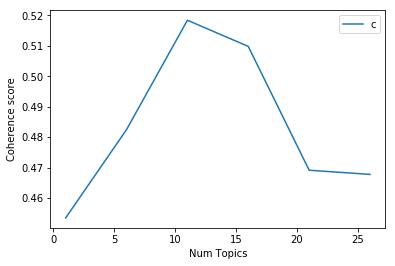

In [78]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values_gta)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [79]:
# Select the model and print the topics
optimal_model_gta = model_list_gta[3]
model_topics_gta = optimal_model_gta.show_topics(formatted=False)
pprint(optimal_model_gta.print_topics(num_words=5))

[(0,
  '0.028*"time" + 0.018*"server" + 0.018*"times" + 0.018*"kill" + '
  '0.016*"heist"'),
 (1,
  '0.031*"make" + 0.016*"add" + 0.013*"minutes" + 0.012*"top" + 0.011*"place"'),
 (2,
  '0.085*"mods" + 0.053*"modding" + 0.048*"rockstar" + 0.041*"mod" + '
  '0.036*"community"'),
 (3, '0.064*"ing" + 0.050*"love" + 0.045*"dont" + 0.019*"life" + 0.017*"guys"'),
 (4,
  '0.081*"pc" + 0.024*"ps" + 0.023*"amazing" + 0.022*"played" + '
  '0.021*"version"'),
 (5,
  '0.046*"car" + 0.017*"friend" + 0.015*"cars" + 0.013*"drive" + '
  '0.011*"shoot"'),
 (6,
  '0.043*"wait" + 0.035*"years" + 0.027*"rockstar" + 0.022*"year" + '
  '0.021*"games"'),
 (7,
  '0.077*"loading" + 0.055*"hours" + 0.029*"screen" + 0.028*"long" + '
  '0.027*"time"'),
 (8,
  '0.028*"games" + 0.026*"playing" + 0.026*"time" + 0.019*"lot" + '
  '0.018*"recommend"'),
 (9,
  '0.030*"world" + 0.026*"auto" + 0.025*"theft" + 0.025*"grand" + '
  '0.019*"character"'),
 (10,
  '0.049*"rockstar" + 0.028*"steam" + 0.026*"work" + 0.026*"fix" 

In [80]:
# Build LDA model
lda_model_gta = gensim.models.ldamodel.LdaModel(corpus=corpus_gta,
                                           id2word=dictionary,
                                           num_topics=11, 
                                           random_state=100,
                                           update_every=2,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis_gta = pyLDAvis.gensim.prepare(lda_model_gta, corpus_gta, dictionary)
vis_gta

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.446856 -0.124719       1        1  73.158089
4     -0.139259  0.373578       2        1  10.386709
2     -0.084881 -0.099351       3        1   6.910189
8      0.042260 -0.035248       4        1   2.807472
0      0.062765 -0.003275       5        1   1.445907
3      0.096325 -0.019095       6        1   1.373118
5      0.096564 -0.018295       7        1   1.202765
1      0.096999 -0.017701       8        1   1.000018
9      0.087461 -0.021781       9        1   0.973540
7      0.094856 -0.017134      10        1   0.424109
10     0.093767 -0.016981      11        1   0.318084, topic_info=      Category         Freq         Term        Total  loglift  logprob
134    Default   943.000000          got   943.000000  30.0000  30.0000
545    Default   560.000000         free   560.000000  29.0000  29.0000
157    Default   606.000000       banned   606.000000  28.0000  28.0000
235    Default   879.000000      loading   879.000000  27.0000  27.0000
39     Default   632.000000         wait   632.000000  26.0000  26.0000
138    Default   905.000000        hours   905.000000  25.0000  25.0000
236    Default   439.000000       reason   439.000000  24.0000  24.0000
247    Default   299.000000          ban   299.000000  23.0000  23.0000
285    Default   785.000000         make   785.000000  22.0000  22.0000
603    Default   207.000000      product   207.000000  21.0000  21.0000
709    Default   202.000000     received   202.000000  20.0000  20.0000
1024   Default   435.000000     graphics   435.000000  19.0000  19.0000
10     Default  3148.000000          gta  3148.000000  18.0000  18.0000
22     Default  2968.000000       online  2968.000000  17.0000  17.0000
631    Default   300.000000        price   300.000000  16.0000  16.0000
82     Default   553.000000        world   553.000000  15.0000  15.0000
22234  Default   225.000000          kyq   225.000000  14.0000  14.0000
22233  Default   225.000000         dcsu   225.000000  13.0000  13.0000
22236  Default   223.000000        pxpxp   223.000000  12.0000  12.0000
697    Default   450.000000         long   450.000000  11.0000  11.0000
512    Default   357.000000        steam   357.000000  10.0000  10.0000
1296   Default   289.000000     negative   289.000000   9.0000   9.0000
274    Default   257.000000         hard   257.000000   8.0000   8.0000
252    Default   200.000000         club   200.000000   7.0000   7.0000
1033   Default   407.000000     missions   407.000000   6.0000   6.0000
374    Default   306.000000       screen   306.000000   5.0000   5.0000
7      Default   333.000000     gameplay   333.000000   4.0000   4.0000
1192   Default   358.000000      minutes   358.000000   3.0000   3.0000
320    Default   401.000000      support   401.000000   2.0000   2.0000
275    Default   394.000000       heists   394.000000   1.0000   1.0000
...        ...          ...          ...          ...      ...      ...
3923   Topic11     3.378101       hoping     4.128209   5.5501  -5.3394
2342   Topic11     2.580559        solve     3.330702   5.4954  -5.6087
8815   Topic11     1.991928    warehouse     2.742056   5.4310  -5.8676
469    Topic11     1.470207        march     2.220306   5.3384  -6.1713
2114   Topic11     0.087794         cnts     0.837848   3.4948  -8.9895
21291  Topic11     0.027210         lest     0.782484   2.3917 -10.1609
23898  Topic11     0.027037          nis     0.790132   2.3756 -10.1673
23899  Topic11     0.027037           pe     0.790132   2.3756 -10.1673
13504  Topic11     0.026645    everyting     0.782025   2.3713 -10.1819
24907  Topic11     0.026435  anythingits     0.781621   2.3639 -10.1898
24908  Topic11     0.026435         pece     0.781621   2.3639 -10.1898
24909  Topic11     0.026435       tryint     0.781621   2.3639 -10.1898
21992  Topic11     0.026434    problemsi     0.785944   2.3584 -10.1898
16176  Topic11 

Topic: 
Apparently, we can see there are some disctinct topics: 

1. Game description: One topic is describing the game. It has key word like: theft, auto, open, world
2. Game experience: One topic might be talking about trasaction experience: it has key words like: money, free, cards , buy
3. Game experience: One topic is talking about the waitime in game. It mentioned: loading, hours, long, time

### Summary

The goal of this project is to give developers an idea of what kind of topics gamers are talking about in the community, what they are concerning and what are their needs. Topic modeling gives the ability to handle thousands of reviews and classify them into optimal numbers of clusters. Developers could utilize this outcomes to havea a overall understanding of reviews, also they could dig further into specific topic by looking sample reviews under that related topic.